# Dataset Exploration
In this notebook, exploratory analysis is performed on the dataset in order to identify patterns, attributes, or other important information that could be of help in the subsequent modelling and predictions. The fully-featured dataset will be loaded and standardized before use

In [1]:
# Change directory for cleaner paths
%cd ..

C:\Users\georg\Documents\msc-project


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
df = pd.read_csv("data/interim/tracks.csv")

### Data Overview
We initially generate an overview of the dataset using Pandas' `describe()`

In [4]:
df.describe()

,views,videos,tt_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,9.352000e+03,9352.000000,9.352000e+03,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9.352000e+03,9352.000000
mean,4.173006e+06,6.315441,6.425985e+18,51.681779,0.640772,0.609691,5.328058,-8.226373,0.568328,0.102834,0.312711,0.135981,0.181909,0.514009,121.362080,2.059791e+05,3.933383
std,1.295376e+07,34.996233,1.548711e+18,23.695767,0.176193,0.229443,3.618172,5.027105,0.495336,0.108549,0.313268,0.296331,0.146907,0.257345,29.342932,1.185772e+05,0.388518
min,0.000000e+00,1.000000,1.116600e+04,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.654000e+03,0.000000
25%,5.850000e+04,1.000000,6.733061e+18,36.000000,0.540000,0.462000,2.000000,-9.696500,0.000000,0.037900,0.043975,0.000000,0.094300,0.308000,98.746000,1.623990e+05,4.000000
50%,1.818000e+05,1.000000,6.819044e+18,56.000000,0.668000,0.644000,6.000000,-6.923500,1.000000,0.055700,0.189000,0.000011,0.123000,0.519000,120.987500,2.003290e+05,4.000000
75%,1.500000e+06,4.000000,6.945140e+18,71.000000,0.767000,0.789000,8.000000,-5.157000,1.000000,0.118000,0.538000,0.011200,0.226000,0.722000,139.977250,2.382092e+05,4.000000
max,3.100000e+08,1430.000000,7.025020e+18,100.000000,0.992000,1.000000,11.000000,1.906000,1.000000,0.956000,0.996000,1.000000,0.994000,1.000000,220.099000,5.951139e+06,5.000000


### Distribution analysis
The target variable (`views`) varies vastly in terms of magnitude, with values ranging from <1000 to millions. In order to attempt to create a reasonable separation of different video popularities, a histogram of view counts is created using 10 different orders of magnitude as buckets.

(array([1.000e+00, 4.000e+00, 1.280e+02, 3.240e+02, 5.390e+02, 3.783e+03,
        2.110e+03, 1.269e+03, 1.051e+03, 1.420e+02]),
 array([0.47712125, 1.2785453 , 2.07996934, 2.88139339, 3.68281743,
        4.48424147, 5.28566552, 6.08708956, 6.88851361, 7.68993765,
        8.49136169]),
 <BarContainer object of 10 artists>)

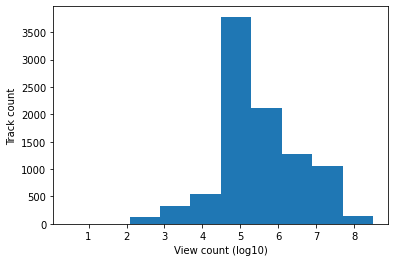

In [5]:
views = df['views']

plt.xlabel("View count (log10)")
plt.ylabel("Track count")
plt.hist(np.log10(views[views > 0]),bins=10)

The above histogram suggests that the majority of tracks have views in the (5e+04, 1e05) range. As such, at least 3 different popularity ranges can be identified. The ones below this range, in the range, and above the range. A reasonable definition for a "viral" video is one whose views are above this middle range.

In [7]:
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms',
    'popularity'
]

data = df[features]
data_std = MinMaxScaler().fit_transform(data)
data_std = pd.DataFrame(data_std,columns=features)

### Correlation
The graph below visualizes the correlation between the features and target variables. There seems to be astrong correlation between loudness and energy, as well as valence and danceability. Other noteble correlations are energy and danceability, and loudness and valence. A relatively strong negative correlation can be observed between acousticness and energy, and acousticness and loudness. 

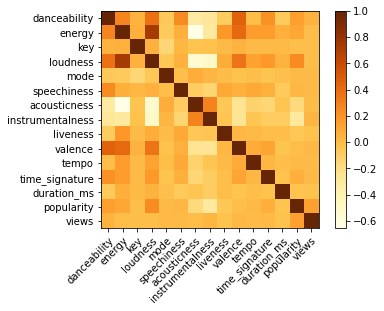

In [8]:
labels = features + ['views']
fig, ax = plt.subplots()
im = ax.imshow(df[labels].corr('pearson'),cmap='YlOrBr')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

### Feature Exploration

The categorical features of the dataset, namely the key, mode, and time signature will be aggregated and plotted against the total number of views, then each of the continuous features will also be plotted against the views of each video.

<BarContainer object of 5 artists>

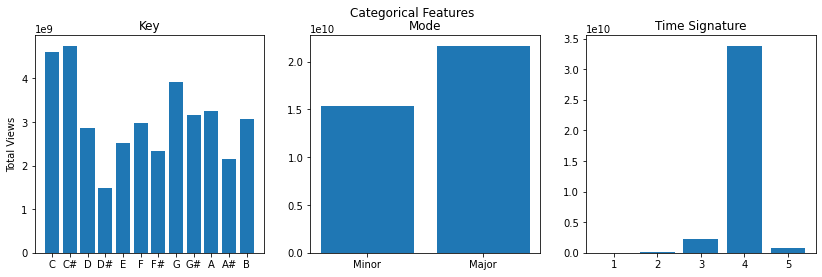

In [9]:
views_per_key = df.groupby("key").sum()['views']
views_per_mode = df.groupby("mode").sum()['views']
views_per_ts = df.groupby("time_signature").sum()['views']

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
fig.suptitle("Categorical Features")

keys = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
ax1.set_title("Key")
ax1.set_ylabel("Total Views")
ax1.bar(keys,views_per_key)

ax2.set_title("Mode")
ax2.bar(['Minor','Major'],views_per_mode)

ax3.set_title("Time Signature")
ax3.bar(np.arange(5)+1,views_per_ts)

Songs written in the keys of C and C# major seem to be more popular overall, as well as songs using 4 beats per measure.

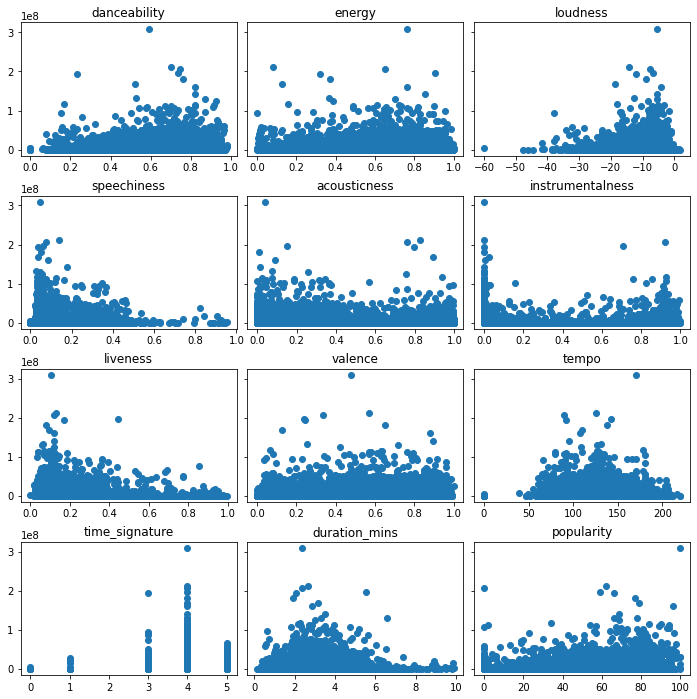

In [12]:
continuous = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_mins',
    'popularity'
]
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(4,3,wspace=0.05,hspace=.3)
axs = gs.subplots(sharey=True)
df['duration_mins'] = df['duration_ms'] / (60 * 1000)

for idx,feature in enumerate(continuous):
    x = int(idx / 3)
    y = idx - x*3
    ax = axs[x,y]
    ax.set_title(feature)
    if feature == 'duration_mins':
        # Remove outliers for cleaner plot
        mask = df[feature] < 10
        ax.scatter(df[feature][mask],df['views'][mask])
    else:
        ax.scatter(df[feature],df['views'])

Louder songs are observed to perform better in terms of views, as well as songs with a tempo between 100-150 bpm and a duration between 2-4 minutes.